<a href="https://colab.research.google.com/github/RealThanosP/pred-main-mod/blob/main/Data_features_Dimitris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clone repository from github

Τα πρώτα ειναι copy paste απο τον κώδικα του θανου

In [1]:
# Load the data on the server session
!git clone https://github.com/RealThanosP/pred-main-mod

# Change your working directory inside the repository
%cd pred-main-mod

Cloning into 'pred-main-mod'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 156 (delta 85), reused 2 (delta 0), pack-reused 28 (from 2)
Receiving objects: 100% (156/156), 95.70 MiB | 4.41 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Updating files: 100% (29/29), done.
/content/pred-main-mod


# Review dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import os
import seaborn as sns

###Getting the sensor files in a list

In [3]:
folder_path = "data/condition+monitoring+of+hydraulic+systems"

# Define the list of sensors and their corresponding column names
sensors = [
    "PS1", "PS2", "PS3", "PS4", "PS5", "PS6",  # Pressure sensors
    "EPS1",  # Motor power
    "FS1", "FS2",  # Volume flow
    "TS1", "TS2", "TS3", "TS4",  # Temperature sensors
    "VS1",  # Vibration
    "CE",  # Cooling efficiency
    "CP",  # Cooling power
    "SE"  # Efficiency factor
]

In [4]:
# Gets all the text files from dataset
txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

# Keeps only the data that have a sensor name in the filename
sensor_file_path_list = [f"{folder_path}/{f}" for f in txt_files if any(sensor in f for sensor in sensors)]
sensor_file_path_list.sort()

###Loading Data

Based on the description the classification for the data is:

The target condition values are cycle-wise annotated in �profile.txt� (tab-delimited). As before, the row number represents the cycle number. The columns are

1: Cooler condition / %: 3: close to total failure 20: reduced effifiency 100: full efficiency

2: Valve condition / %: 100: optimal switching behavior 90: small lag 80: severe lag 73: close to total failure

3: Internal pump leakage: 0: no leakage 1: weak leakage 2: severe leakage

4: Hydraulic accumulator / bar: 130: optimal pressure 115: slightly reduced pressure 100: severely reduced pressure 90: close to total failure

5: stable flag: 0: conditions were stable 1: static conditions might not have been reached yet

In [5]:
# profile
profile = pd.read_csv("data/condition+monitoring+of+hydraulic+systems/profile.txt", sep="\t", header=None)
profile.columns = ["Cooler condition %", "Valve condition %", "Internal pump leakage", "Hydraulic accumulator / bar", "stable flag"]
profile.insert(0, "Cycle", [i + 1 for i in range(len(profile))]) # Insert Cycle column for easier plotting
profile

,Cycle,Cooler condition %,Valve condition %,Internal pump leakage,Hydraulic accumulator / bar,stable flag
0,1,3,100,0,130,1
1,2,3,100,0,130,1
2,3,3,100,0,130,1
3,4,3,100,0,130,1
4,5,3,100,0,130,1
...,...,...,...,...,...,...
2200,2201,100,100,0,90,0
2201,2202,100,100,0,90,0
2202,2203,100,100,0,90,0
2203,2204,100,100,0,90,0


###Data plotting (profile)

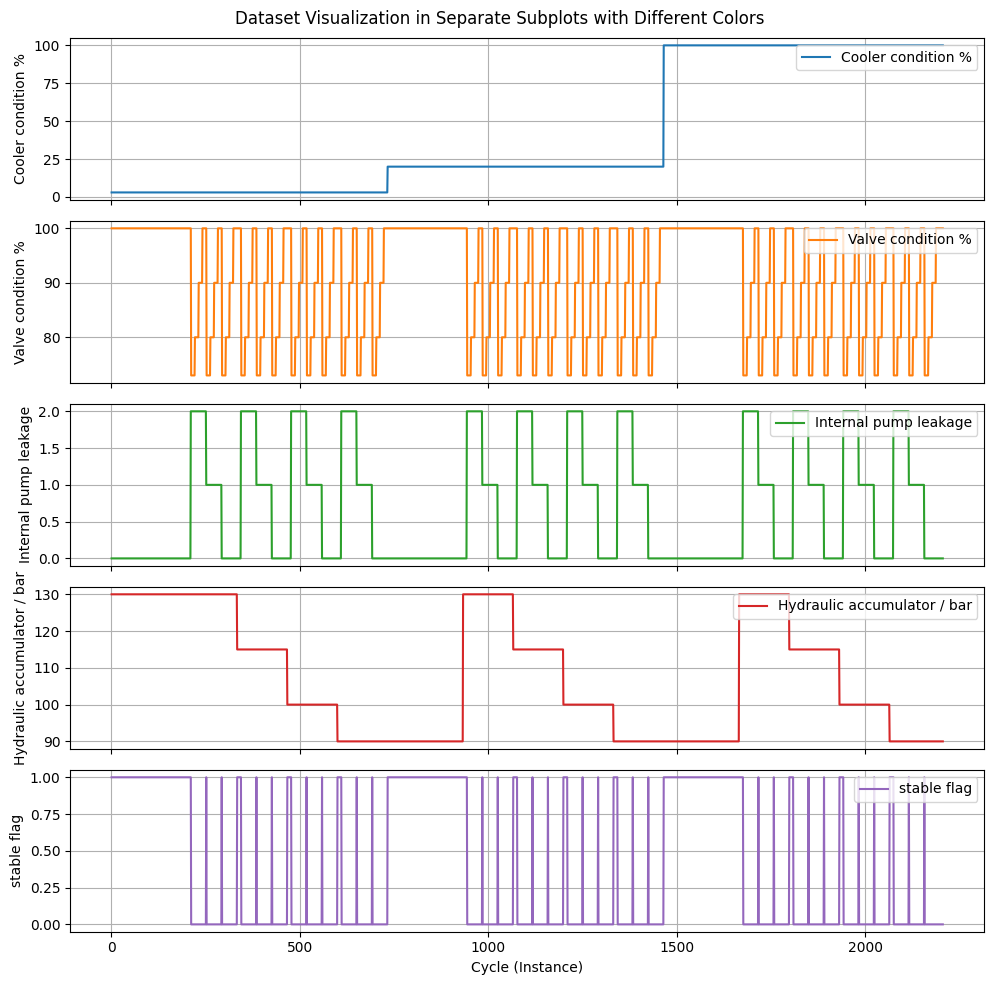

In [6]:
# Define colors for each subplot
colors = sns.color_palette("tab10", len(profile.columns) - 1)  # Use seaborn's color palette

# Create subplots
fig, axes = plt.subplots(nrows=len(profile.columns)-1, ncols=1, figsize=(10, 10), sharex=True)

# Plot each column in a separate subplot with a unique color
for i, (col, color) in enumerate(zip(profile.columns[1:], colors)):  # Exclude "Cycle"
    axes[i].plot(profile["Cycle"], profile[col], label=col, color=color, linewidth=1.5)
    axes[i].set_ylabel(col)
    axes[i].legend(loc="upper right")
    axes[i].grid(True)

# Set common X-axis label
axes[-1].set_xlabel("Cycle (Instance)")
fig.suptitle("Dataset Visualization in Separate Subplots with Different Colors")

plt.tight_layout()
plt.show()

#Data preperation

Θα δοκιμασω να κανω ολα τα αρχεια των αισθητηρων να περιεχουν πληροφορειες mean, rms, max, min κλπ, να τα κάνω ένα ενιαίο dataset (και το profile μεσα) και να βαλω ως target column το stable flag.

In [7]:
import pandas as pd
import os

# load all the files as seperate DataFrames with the file name as name
for file_path in sensor_file_path_list:
    # remove the .txt
    file_name = os.path.splitext(os.path.basename(file_path))[0]

    # read the file and save it with the right name
    globals()[file_name] = pd.read_csv(file_path, sep="\t", header=None)

### Feature engineering

In [8]:
# function that does the feature engineering
def create_stats(sensor_name):
    # We get the DataFrame dynamically from the name
    df = globals()[sensor_name]

    # Calculate statistics
    stats = pd.DataFrame({
        'mean'+ sensor_name: df.mean(axis=1),
        'std'+ sensor_name: df.std(axis=1),
        'min'+ sensor_name: df.min(axis=1),
        'max'+ sensor_name: df.max(axis=1),
        'range'+ sensor_name: df.max(axis=1) - df.min(axis=1),
        'rms'+ sensor_name: (df.pow(2).mean(axis=1)).pow(0.5)
    })

    return stats

In [9]:
# dictionary to save the names as keys and the dataframes as values
stats_dfs = {}

for sensor in sensors:
    stats_dfs[f'{sensor}_stats'] = create_stats(sensor)

# Converts the keys of the dictionary to variables
globals().update(stats_dfs)

In [10]:
PS1_stats

,meanPS1,stdPS1,minPS1,maxPS1,rangePS1,rmsPS1
0,160.673492,13.939309,145.83,191.51,45.68,161.276914
1,160.603320,14.118967,145.73,191.47,45.74,161.222636
2,160.347720,14.192619,145.37,191.41,46.04,160.974495
3,160.188088,14.227803,145.14,191.34,46.20,160.818594
4,160.000472,14.276434,144.95,191.41,46.46,160.636028
...,...,...,...,...,...,...
2200,161.227572,13.987129,146.69,191.81,45.12,161.833053
2201,161.206070,14.001418,146.64,191.81,45.17,161.812867
2202,161.192120,13.988350,146.63,191.84,45.21,161.797840
2203,161.208917,13.985248,146.65,191.77,45.12,161.814305


###Create correlation between profile columns

Ιn the matrix below the closer the value of a cell is to 1, the more correlated are the corresponding data.

For example, if Cooler condition % has a correlation of -0.9 with the stable flag, it means that the worse the cooler, the more likely it is that the engine is not stable.

From the last column we can make the weights of the maintenance score

In [11]:
columns_of_interest = [
    'Cooler condition %',
    'Valve condition %',
    'Internal pump leakage',
    'Hydraulic accumulator / bar',
    'stable flag'
]

correlation_matrix = profile[columns_of_interest].corr()
correlation_matrix

,Cooler condition %,Valve condition %,Internal pump leakage,Hydraulic accumulator / bar,stable flag
Cooler condition %,1.000000,0.004952,-0.004656,-0.203954,-0.004105
Valve condition %,0.004952,1.000000,-0.352610,-0.082222,0.629433
Internal pump leakage,-0.004656,-0.352610,1.000000,0.077303,-0.549678
Hydraulic accumulator / bar,-0.203954,-0.082222,0.077303,1.000000,-0.120817
stable flag,-0.004105,0.629433,-0.549678,-0.120817,1.000000


Heatmap

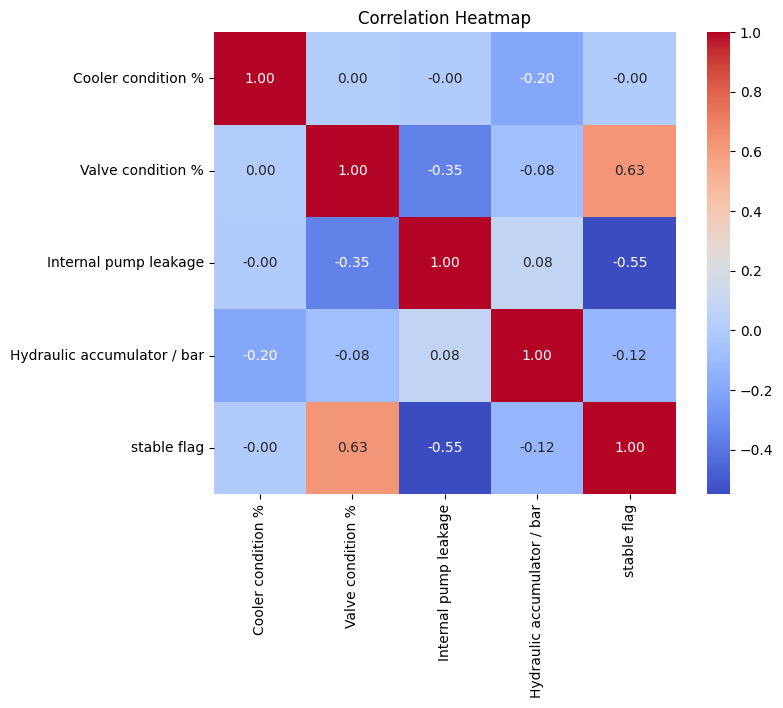

In [12]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.show()

Calculating the weights

In [13]:
weights = correlation_matrix['stable flag'].drop('stable flag')

weights_dict = weights.to_dict() #convert to dictionary for easier handling

for feature, weight in weights_dict.items():
    print(f"{feature}: {weight}")

Cooler condition %: -0.004105045484504893
Valve condition %: 0.6294329131160301
Internal pump leakage: -0.5496780139511884
Hydraulic accumulator / bar: -0.12081669991835049


Normalizing the weights to have sum equal to 1

In [14]:
total = sum(abs(w) for w in weights_dict.values())
normalized_weights = {k: v / total for k, v in weights_dict.items()}
normalized_weights

{'Cooler condition %': -0.003147962141722411,
 'Valve condition %': 0.4826818579045035,
 'Internal pump leakage': -0.4215216578201211,
 'Hydraulic accumulator / bar': -0.09264852213365316}

### Compine the data by category

In [15]:
combined_stats_fs = pd.concat([FS1_stats, FS2_stats], axis=1)
combined_stats_ps = pd.concat([PS1_stats, PS2_stats, PS3_stats, PS4_stats, PS5_stats, PS6_stats], axis=1)
combined_stats_ts = pd.concat([TS1_stats, TS2_stats, TS3_stats, TS4_stats], axis=1)

In [16]:
combined_stats_ps

,meanPS1,stdPS1,minPS1,maxPS1,rangePS1,rmsPS1,meanPS2,stdPS2,minPS2,maxPS2,...,minPS5,maxPS5,rangePS5,rmsPS5,meanPS6,stdPS6,minPS6,maxPS6,rangePS6,rmsPS6
0,160.673492,13.939309,145.83,191.51,45.68,161.276914,109.466914,47.114508,0.0,156.99,...,9.681,10.016,0.335,9.842564,9.728097,0.085366,9.568,9.887,0.319,9.728472
1,160.603320,14.118967,145.73,191.47,45.74,161.222636,109.354890,47.045611,0.0,157.56,...,9.557,9.745,0.188,9.635219,9.529488,0.036316,9.454,9.637,0.183,9.529557
2,160.347720,14.192619,145.37,191.41,46.04,160.974495,109.158845,46.992060,0.0,156.97,...,9.455,9.640,0.185,9.530615,9.427949,0.036031,9.348,9.536,0.188,9.428018
3,160.188088,14.227803,145.14,191.34,46.20,160.818594,109.064807,46.972221,0.0,156.44,...,9.363,9.535,0.172,9.438899,9.337430,0.037375,9.257,9.431,0.174,9.337504
4,160.000472,14.276434,144.95,191.41,46.46,160.636028,108.931434,46.874946,0.0,158.13,...,9.290,9.443,0.153,9.358809,9.260636,0.028592,9.195,9.342,0.147,9.260680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,161.227572,13.987129,146.69,191.81,45.12,161.833053,109.779581,47.253414,0.0,167.49,...,9.910,10.028,0.118,9.972062,9.850361,0.021802,9.790,9.905,0.115,9.850385
2201,161.206070,14.001418,146.64,191.81,45.17,161.812867,109.787481,47.247815,0.0,167.27,...,9.901,10.014,0.113,9.966208,9.844854,0.021932,9.777,9.894,0.117,9.844878
2202,161.192120,13.988350,146.63,191.84,45.21,161.797840,109.756174,47.244805,0.0,167.34,...,9.898,10.019,0.121,9.964355,9.842628,0.022094,9.777,9.896,0.119,9.842653
2203,161.208917,13.985248,146.65,191.77,45.12,161.814305,109.793884,47.240806,0.0,167.52,...,9.898,10.022,0.124,9.968260,9.846690,0.023185,9.767,9.900,0.133,9.846717


###Compine all the data

In [17]:
combined_data = pd.concat([combined_stats_fs, combined_stats_ps, combined_stats_ts, CE_stats, CP_stats, EPS1_stats, VS1_stats, SE_stats], axis=1)
combined_data

,meanFS1,stdFS1,minFS1,maxFS1,rangeFS1,rmsFS1,meanFS2,stdFS2,minFS2,maxFS2,...,minVS1,maxVS1,rangeVS1,rmsVS1,meanSE,stdSE,minSE,maxSE,rangeSE,rmsSE
0,6.709815,3.015428,0.0,18.710,18.710,7.355220,10.304592,0.091772,10.148,10.446,...,0.532,0.624,0.092,0.577575,59.157183,23.763984,0.0,79.568,79.568,63.677996
1,6.715315,3.006248,0.0,18.712,18.712,7.356488,10.403098,0.019162,10.352,10.453,...,0.524,0.626,0.102,0.566494,59.335617,23.857918,0.0,80.441,80.441,63.878236
2,6.718522,3.014248,0.0,18.698,18.698,7.362682,10.366250,0.026361,10.296,10.443,...,0.529,0.662,0.133,0.577683,59.543150,23.923381,0.0,80.824,80.824,64.095055
3,6.720565,3.020176,0.0,18.896,18.896,7.366970,10.302678,0.026750,10.241,10.382,...,0.527,0.645,0.118,0.570233,59.794900,24.023005,0.0,80.930,80.930,64.365491
4,6.690308,3.011550,0.0,18.876,18.876,7.335840,10.237750,0.029170,10.179,10.312,...,0.524,0.660,0.136,0.578321,59.455267,23.972262,0.0,81.100,81.100,64.031400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,6.689930,3.001512,0.0,20.228,20.228,7.331386,10.184515,0.013701,10.147,10.224,...,0.512,0.618,0.106,0.551627,59.033100,23.635352,0.0,77.752,77.752,63.515559
2201,6.692182,3.005831,0.0,20.308,20.308,7.335206,10.177767,0.014669,10.133,10.233,...,0.507,0.584,0.077,0.547897,59.068000,23.638396,0.0,77.592,77.592,63.549111
2202,6.693277,2.991333,0.0,20.071,20.071,7.330287,10.176172,0.014749,10.127,10.225,...,0.502,0.597,0.095,0.545755,59.132350,23.633405,0.0,77.773,77.773,63.607104
2203,6.684128,3.003983,0.0,20.280,20.280,7.327103,10.178353,0.014619,10.129,10.230,...,0.502,0.585,0.083,0.537302,58.970800,23.600817,0.0,77.568,77.568,63.445019


In [18]:
# the dataset for scaling
profile_without_first_and_last_columns = profile.iloc[:, 1:-1]
data_for_scalling = pd.concat([combined_data, profile_without_first_and_last_columns], axis=1)
data_for_scalling

,meanFS1,stdFS1,minFS1,maxFS1,rangeFS1,rmsFS1,meanFS2,stdFS2,minFS2,maxFS2,...,meanSE,stdSE,minSE,maxSE,rangeSE,rmsSE,Cooler condition %,Valve condition %,Internal pump leakage,Hydraulic accumulator / bar
0,6.709815,3.015428,0.0,18.710,18.710,7.355220,10.304592,0.091772,10.148,10.446,...,59.157183,23.763984,0.0,79.568,79.568,63.677996,3,100,0,130
1,6.715315,3.006248,0.0,18.712,18.712,7.356488,10.403098,0.019162,10.352,10.453,...,59.335617,23.857918,0.0,80.441,80.441,63.878236,3,100,0,130
2,6.718522,3.014248,0.0,18.698,18.698,7.362682,10.366250,0.026361,10.296,10.443,...,59.543150,23.923381,0.0,80.824,80.824,64.095055,3,100,0,130
3,6.720565,3.020176,0.0,18.896,18.896,7.366970,10.302678,0.026750,10.241,10.382,...,59.794900,24.023005,0.0,80.930,80.930,64.365491,3,100,0,130
4,6.690308,3.011550,0.0,18.876,18.876,7.335840,10.237750,0.029170,10.179,10.312,...,59.455267,23.972262,0.0,81.100,81.100,64.031400,3,100,0,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,6.689930,3.001512,0.0,20.228,20.228,7.331386,10.184515,0.013701,10.147,10.224,...,59.033100,23.635352,0.0,77.752,77.752,63.515559,100,100,0,90
2201,6.692182,3.005831,0.0,20.308,20.308,7.335206,10.177767,0.014669,10.133,10.233,...,59.068000,23.638396,0.0,77.592,77.592,63.549111,100,100,0,90
2202,6.693277,2.991333,0.0,20.071,20.071,7.330287,10.176172,0.014749,10.127,10.225,...,59.132350,23.633405,0.0,77.773,77.773,63.607104,100,100,0,90
2203,6.684128,3.003983,0.0,20.280,20.280,7.327103,10.178353,0.014619,10.129,10.230,...,58.970800,23.600817,0.0,77.568,77.568,63.445019,100,100,0,90


### Scaling the data

εδω καλο θα ηταν να ονοματησω σωστα τισ στηλες του Dataframe
**FIX το εκανε ο Θάνος :) **

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()

scaled_data = scaler.fit_transform(data_for_scalling)
scaled_data_dtset = pd.DataFrame(scaled_data, columns=data_for_scalling.columns) # Just a columns argument needed
scaled_data_dtset

,meanFS1,stdFS1,minFS1,maxFS1,rangeFS1,rmsFS1,meanFS2,stdFS2,minFS2,maxFS2,...,meanSE,stdSE,minSE,maxSE,rangeSE,rmsSE,Cooler condition %,Valve condition %,Internal pump leakage,Hydraulic accumulator / bar
0,0.495101,-0.130443,-0.021301,-3.143240,-3.143235,0.546497,1.458639,18.562454,1.206381,1.677334,...,0.431929,-0.202694,0.0,-0.063981,-0.063981,0.456140,-0.902469,0.87141,-0.819277,1.387554
1,0.500427,-0.179022,-0.021301,-3.138813,-3.138809,0.548169,1.677960,0.497722,1.653167,1.693157,...,0.451847,-0.153763,0.0,0.091880,0.091880,0.485438,-0.902469,0.87141,-0.819277,1.387554
2,0.503533,-0.136685,-0.021301,-3.169798,-3.169794,0.556338,1.595919,2.288859,1.530520,1.670553,...,0.475014,-0.119662,0.0,0.160258,0.160258,0.517161,-0.902469,0.87141,-0.819277,1.387554
3,0.505511,-0.105318,-0.021301,-2.731581,-2.731577,0.561995,1.454379,2.385506,1.410063,1.532668,...,0.503117,-0.067767,0.0,0.179183,0.179183,0.556728,-0.902469,0.87141,-0.819277,1.387554
4,0.476211,-0.150963,-0.021301,-2.775846,-2.775842,0.520934,1.309819,2.987783,1.274275,1.374439,...,0.465204,-0.094199,0.0,0.209534,0.209534,0.507847,-0.902469,0.87141,-0.819277,1.387554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.475845,-0.204087,-0.021301,0.216421,0.216422,0.515060,1.191293,-0.860944,1.204191,1.175523,...,0.418077,-0.269700,0.0,-0.388199,-0.388199,0.432374,1.386695,0.87141,-0.819277,-1.046703
2201,0.478025,-0.181232,-0.021301,0.393479,0.393479,0.520099,1.176268,-0.620172,1.173529,1.195866,...,0.421973,-0.268115,0.0,-0.416764,-0.416764,0.437283,1.386695,0.87141,-0.819277,-1.046703
2202,0.479086,-0.257953,-0.021301,-0.131053,-0.131052,0.513611,1.172717,-0.600236,1.160388,1.177783,...,0.429156,-0.270715,0.0,-0.384450,-0.384450,0.445768,1.386695,0.87141,-0.819277,-1.046703
2203,0.470227,-0.191012,-0.021301,0.331509,0.331509,0.509411,1.177575,-0.632400,1.164768,1.189085,...,0.411123,-0.287690,0.0,-0.421049,-0.421049,0.422054,1.386695,0.87141,-0.819277,-1.046703


In [20]:
profile_last_column = profile.iloc[:, -1]
total_data = pd.concat([scaled_data_dtset, profile_last_column], axis = 1)
total_data

,meanFS1,stdFS1,minFS1,maxFS1,rangeFS1,rmsFS1,meanFS2,stdFS2,minFS2,maxFS2,...,stdSE,minSE,maxSE,rangeSE,rmsSE,Cooler condition %,Valve condition %,Internal pump leakage,Hydraulic accumulator / bar,stable flag
0,0.495101,-0.130443,-0.021301,-3.143240,-3.143235,0.546497,1.458639,18.562454,1.206381,1.677334,...,-0.202694,0.0,-0.063981,-0.063981,0.456140,-0.902469,0.87141,-0.819277,1.387554,1
1,0.500427,-0.179022,-0.021301,-3.138813,-3.138809,0.548169,1.677960,0.497722,1.653167,1.693157,...,-0.153763,0.0,0.091880,0.091880,0.485438,-0.902469,0.87141,-0.819277,1.387554,1
2,0.503533,-0.136685,-0.021301,-3.169798,-3.169794,0.556338,1.595919,2.288859,1.530520,1.670553,...,-0.119662,0.0,0.160258,0.160258,0.517161,-0.902469,0.87141,-0.819277,1.387554,1
3,0.505511,-0.105318,-0.021301,-2.731581,-2.731577,0.561995,1.454379,2.385506,1.410063,1.532668,...,-0.067767,0.0,0.179183,0.179183,0.556728,-0.902469,0.87141,-0.819277,1.387554,1
4,0.476211,-0.150963,-0.021301,-2.775846,-2.775842,0.520934,1.309819,2.987783,1.274275,1.374439,...,-0.094199,0.0,0.209534,0.209534,0.507847,-0.902469,0.87141,-0.819277,1.387554,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.475845,-0.204087,-0.021301,0.216421,0.216422,0.515060,1.191293,-0.860944,1.204191,1.175523,...,-0.269700,0.0,-0.388199,-0.388199,0.432374,1.386695,0.87141,-0.819277,-1.046703,0
2201,0.478025,-0.181232,-0.021301,0.393479,0.393479,0.520099,1.176268,-0.620172,1.173529,1.195866,...,-0.268115,0.0,-0.416764,-0.416764,0.437283,1.386695,0.87141,-0.819277,-1.046703,0
2202,0.479086,-0.257953,-0.021301,-0.131053,-0.131052,0.513611,1.172717,-0.600236,1.160388,1.177783,...,-0.270715,0.0,-0.384450,-0.384450,0.445768,1.386695,0.87141,-0.819277,-1.046703,0
2203,0.470227,-0.191012,-0.021301,0.331509,0.331509,0.509411,1.177575,-0.632400,1.164768,1.189085,...,-0.287690,0.0,-0.421049,-0.421049,0.422054,1.386695,0.87141,-0.819277,-1.046703,0


# Feature creation

### Reviewing the data

In [21]:
total_data

,meanFS1,stdFS1,minFS1,maxFS1,rangeFS1,rmsFS1,meanFS2,stdFS2,minFS2,maxFS2,...,stdSE,minSE,maxSE,rangeSE,rmsSE,Cooler condition %,Valve condition %,Internal pump leakage,Hydraulic accumulator / bar,stable flag
0,0.495101,-0.130443,-0.021301,-3.143240,-3.143235,0.546497,1.458639,18.562454,1.206381,1.677334,...,-0.202694,0.0,-0.063981,-0.063981,0.456140,-0.902469,0.87141,-0.819277,1.387554,1
1,0.500427,-0.179022,-0.021301,-3.138813,-3.138809,0.548169,1.677960,0.497722,1.653167,1.693157,...,-0.153763,0.0,0.091880,0.091880,0.485438,-0.902469,0.87141,-0.819277,1.387554,1
2,0.503533,-0.136685,-0.021301,-3.169798,-3.169794,0.556338,1.595919,2.288859,1.530520,1.670553,...,-0.119662,0.0,0.160258,0.160258,0.517161,-0.902469,0.87141,-0.819277,1.387554,1
3,0.505511,-0.105318,-0.021301,-2.731581,-2.731577,0.561995,1.454379,2.385506,1.410063,1.532668,...,-0.067767,0.0,0.179183,0.179183,0.556728,-0.902469,0.87141,-0.819277,1.387554,1
4,0.476211,-0.150963,-0.021301,-2.775846,-2.775842,0.520934,1.309819,2.987783,1.274275,1.374439,...,-0.094199,0.0,0.209534,0.209534,0.507847,-0.902469,0.87141,-0.819277,1.387554,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.475845,-0.204087,-0.021301,0.216421,0.216422,0.515060,1.191293,-0.860944,1.204191,1.175523,...,-0.269700,0.0,-0.388199,-0.388199,0.432374,1.386695,0.87141,-0.819277,-1.046703,0
2201,0.478025,-0.181232,-0.021301,0.393479,0.393479,0.520099,1.176268,-0.620172,1.173529,1.195866,...,-0.268115,0.0,-0.416764,-0.416764,0.437283,1.386695,0.87141,-0.819277,-1.046703,0
2202,0.479086,-0.257953,-0.021301,-0.131053,-0.131052,0.513611,1.172717,-0.600236,1.160388,1.177783,...,-0.270715,0.0,-0.384450,-0.384450,0.445768,1.386695,0.87141,-0.819277,-1.046703,0
2203,0.470227,-0.191012,-0.021301,0.331509,0.331509,0.509411,1.177575,-0.632400,1.164768,1.189085,...,-0.287690,0.0,-0.421049,-0.421049,0.422054,1.386695,0.87141,-0.819277,-1.046703,0


### Creating the maintenance_score (based on the profile data)

Defining the weights

**NOTE:** Τα weights τα έβαλα ψιλο-αφθαίρετα

In [22]:
weights = {
    '% Cooler conditions': 0.6,   # Heavily impacts efficiency
    '% Valve conditions': 0.5,    # Valve issues degrade performance quickly
    'Internal pump leakage numbers': 0.7,  # Leakage is a major issue
    'Hydraulic accumulator / bar': 0.5,    # Pressure drop affects system performance
    'stable_flag': -0.3  # If unstable, slightly lower maintenance score (uncertainty)
}

Υπολογίζουμε το maintenance_score με βάση τα

In [23]:
def compute_maintenance_score(row, weights):
    # Compute an initial score using the provided weights
    base_score = (row['Cooler condition %'] * weights['% Cooler conditions'] +
                  row['Valve condition %'] * weights['% Valve conditions'] +
                  row['Internal pump leakage'] * weights['Internal pump leakage numbers'] +
                  row['Hydraulic accumulator / bar'] * weights['Hydraulic accumulator / bar'])

    # If stable_flag is 0 (machine is stable), reduce the score
    if row['stable flag'] == 0:
        return base_score * (1 + weights['stable_flag'])  # Apply stability weight

    return base_score  # Return the raw score without capping at 1

total_data['maintenance_score_raw'] = total_data.apply(lambda row: compute_maintenance_score(row, weights), axis=1)

# Scale maintenance_score to minMax
min_max_scaler = MinMaxScaler()
total_data['maintenance_score'] = min_max_scaler.fit_transform(total_data[['maintenance_score_raw']])
total_data.drop(columns="maintenance_score_raw", inplace=True)

In [24]:
total_data

,meanFS1,stdFS1,minFS1,maxFS1,rangeFS1,rmsFS1,meanFS2,stdFS2,minFS2,maxFS2,...,minSE,maxSE,rangeSE,rmsSE,Cooler condition %,Valve condition %,Internal pump leakage,Hydraulic accumulator / bar,stable flag,maintenance_score
0,0.495101,-0.130443,-0.021301,-3.143240,-3.143235,0.546497,1.458639,18.562454,1.206381,1.677334,...,0.0,-0.063981,-0.063981,0.456140,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
1,0.500427,-0.179022,-0.021301,-3.138813,-3.138809,0.548169,1.677960,0.497722,1.653167,1.693157,...,0.0,0.091880,0.091880,0.485438,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
2,0.503533,-0.136685,-0.021301,-3.169798,-3.169794,0.556338,1.595919,2.288859,1.530520,1.670553,...,0.0,0.160258,0.160258,0.517161,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
3,0.505511,-0.105318,-0.021301,-2.731581,-2.731577,0.561995,1.454379,2.385506,1.410063,1.532668,...,0.0,0.179183,0.179183,0.556728,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
4,0.476211,-0.150963,-0.021301,-2.775846,-2.775842,0.520934,1.309819,2.987783,1.274275,1.374439,...,0.0,0.209534,0.209534,0.507847,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.475845,-0.204087,-0.021301,0.216421,0.216422,0.515060,1.191293,-0.860944,1.204191,1.175523,...,0.0,-0.388199,-0.388199,0.432374,1.386695,0.87141,-0.819277,-1.046703,0,0.382405
2201,0.478025,-0.181232,-0.021301,0.393479,0.393479,0.520099,1.176268,-0.620172,1.173529,1.195866,...,0.0,-0.416764,-0.416764,0.437283,1.386695,0.87141,-0.819277,-1.046703,0,0.382405
2202,0.479086,-0.257953,-0.021301,-0.131053,-0.131052,0.513611,1.172717,-0.600236,1.160388,1.177783,...,0.0,-0.384450,-0.384450,0.445768,1.386695,0.87141,-0.819277,-1.046703,0,0.382405
2203,0.470227,-0.191012,-0.021301,0.331509,0.331509,0.509411,1.177575,-0.632400,1.164768,1.189085,...,0.0,-0.421049,-0.421049,0.422054,1.386695,0.87141,-0.819277,-1.046703,0,0.382405


### Create Coefficient of Variance (CV)
---
Measures relative variability on the sensor measurements. High CV means erratic sensor motion which may impact maintenance issues.

---
**Formula:** \begin{align*}
          \text{CV} &= \frac{\text{std}}{\text{mean}}
          \end{align*}

In [25]:
def compute_coefficient_variance(row, sensors):
    cv_values = {}
    for name in sensors:
        mean = row[f'mean{name}']
        std = row[f'std{name}']
        cv_values[f'cv{name}'] = std / (mean + 1e-6)  # Avoid division by zero
    return cv_values

In [26]:
# Apply to the dataframe
copy_data = total_data.copy()
cv_df = copy_data.apply(lambda row: compute_coefficient_variance(row, sensors), axis=1, result_type='expand')

# Scale the data
cv_df = pd.DataFrame(scaler.fit_transform(cv_df), columns=cv_df.columns)

# Get the insertion point: 6 columns before the end
insert_at = total_data.shape[1] - 6

# Split original DataFrame into two parts
df_first = total_data.iloc[:, :insert_at]
df_last = total_data.iloc[:, insert_at:]

# places the cv columns before the profile columns and after the statistical data
copy_data = pd.concat([df_first, cv_df, df_last], axis=1)
copy_data

,meanFS1,stdFS1,minFS1,maxFS1,rangeFS1,rmsFS1,meanFS2,stdFS2,minFS2,maxFS2,...,cvVS1,cvCE,cvCP,cvSE,Cooler condition %,Valve condition %,Internal pump leakage,Hydraulic accumulator / bar,stable flag,maintenance_score
0,0.495101,-0.130443,-0.021301,-3.143240,-3.143235,0.546497,1.458639,18.562454,1.206381,1.677334,...,0.046869,22.076806,33.832675,0.062632,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
1,0.500427,-0.179022,-0.021301,-3.138813,-3.138809,0.548169,1.677960,0.497722,1.653167,1.693157,...,0.041463,-7.677607,-0.636859,0.067658,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
2,0.503533,-0.136685,-0.021301,-3.169798,-3.169794,0.556338,1.595919,2.288859,1.530520,1.670553,...,0.033209,-1.189884,0.029237,0.071103,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
3,0.505511,-0.105318,-0.021301,-2.731581,-2.731577,0.561995,1.454379,2.385506,1.410063,1.532668,...,0.035560,-0.492636,0.016621,0.075671,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
4,0.476211,-0.150963,-0.021301,-2.775846,-2.775842,0.520934,1.309819,2.987783,1.274275,1.374439,...,0.038024,-0.031357,0.046900,0.073029,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.475845,-0.204087,-0.021301,0.216421,0.216422,0.515060,1.191293,-0.860944,1.204191,1.175523,...,0.035276,-0.121441,-0.056749,0.055780,1.386695,0.87141,-0.819277,-1.046703,0,0.382405
2201,0.478025,-0.181232,-0.021301,0.393479,0.393479,0.520099,1.176268,-0.620172,1.173529,1.195866,...,0.041215,0.183023,0.049303,0.056158,1.386695,0.87141,-0.819277,-1.046703,0,0.382405
2202,0.479086,-0.257953,-0.021301,-0.131053,-0.131052,0.513611,1.172717,-0.600236,1.160388,1.177783,...,0.038723,0.324309,0.131072,0.056337,1.386695,0.87141,-0.819277,-1.046703,0,0.382405
2203,0.470227,-0.191012,-0.021301,0.331509,0.331509,0.509411,1.177575,-0.632400,1.164768,1.189085,...,0.041473,-0.113212,-0.068310,0.053649,1.386695,0.87141,-0.819277,-1.046703,0,0.382405


### Create Signal Stability Ratio
---
Low stability ratio indicates fluctuations and lead to machine failure. This feature is comparing how close is the machine to its stability limits. Meaning that it compares the mean of the sensor's values to it's range

---

\begin{align*}
          \text{stability} &= \frac{\text{mean}}{\text{range}+ 1 \times 10^{-6}}
          \end{align*}



In [27]:
def compute_stability(row, sensors):
    stability_values = {}
    for name in sensors:
        mean = row[f'mean{name}']
        range = row[f'range{name}']
        stability_values[f'stability{name}'] = mean / (range + 10**(-6))
    return stability_values

stability_df = copy_data.apply(lambda row: compute_stability(row, sensors), axis=1, result_type='expand')
# Scale the data
stability_df = pd.DataFrame(scaler.fit_transform(stability_df), columns=stability_df.columns)

# Get the insertion point: 6 columns before the end
insert_at = total_data.shape[1] - 6

# Split original DataFrame into two parts
df_first = total_data.iloc[:, :insert_at]
df_last = total_data.iloc[:, insert_at:]

# places the cv columns before the profile columns and after the statistical data
copy_data = pd.concat([df_first, stability_df, df_last], axis=1)
copy_data

,meanFS1,stdFS1,minFS1,maxFS1,rangeFS1,rmsFS1,meanFS2,stdFS2,minFS2,maxFS2,...,stabilityVS1,stabilityCE,stabilityCP,stabilitySE,Cooler condition %,Valve condition %,Internal pump leakage,Hydraulic accumulator / bar,stable flag,maintenance_score
0,0.495101,-0.130443,-0.021301,-3.143240,-3.143235,0.546497,1.458639,18.562454,1.206381,1.677334,...,-0.052766,-0.012037,0.019523,-0.011559,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
1,0.500427,-0.179022,-0.021301,-3.138813,-3.138809,0.548169,1.677960,0.497722,1.653167,1.693157,...,-0.050826,-0.013201,-0.003400,0.071536,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
2,0.503533,-0.136685,-0.021301,-3.169798,-3.169794,0.556338,1.595919,2.288859,1.530520,1.670553,...,-0.048344,-0.017628,1.399002,0.057624,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
3,0.505511,-0.105318,-0.021301,-2.731581,-2.731577,0.561995,1.454379,2.385506,1.410063,1.532668,...,-0.049578,-0.022119,3.268475,0.056511,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
4,0.476211,-0.150963,-0.021301,-2.775846,-2.775842,0.520934,1.309819,2.987783,1.274275,1.374439,...,-0.047814,-0.047884,-1.600777,0.052326,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.475845,-0.204087,-0.021301,0.216421,0.216422,0.515060,1.191293,-0.860944,1.204191,1.175523,...,-0.048499,-0.057282,-0.126423,0.028847,1.386695,0.87141,-0.819277,-1.046703,0,0.382405
2201,0.478025,-0.181232,-0.021301,0.393479,0.393479,0.520099,1.176268,-0.620172,1.173529,1.195866,...,-0.050745,0.005148,0.148505,0.029306,1.386695,0.87141,-0.819277,-1.046703,0,0.382405
2202,0.479086,-0.257953,-0.021301,-0.131053,-0.131052,0.513611,1.172717,-0.600236,1.160388,1.177783,...,-0.049073,0.013008,1.070343,0.028567,1.386695,0.87141,-0.819277,-1.046703,0,0.382405
2203,0.470227,-0.191012,-0.021301,0.331509,0.331509,0.509411,1.177575,-0.632400,1.164768,1.189085,...,-0.049331,0.168655,-0.418248,0.029563,1.386695,0.87141,-0.819277,-1.046703,0,0.382405


### Creating Exponential Moving Average (EMA)
---
Smoothens the signal and helps detect long-term trends on slow mechanical tear

In [28]:
df_ema = copy_data.copy()

In [29]:
df_ema

,meanFS1,stdFS1,minFS1,maxFS1,rangeFS1,rmsFS1,meanFS2,stdFS2,minFS2,maxFS2,...,stabilityVS1,stabilityCE,stabilityCP,stabilitySE,Cooler condition %,Valve condition %,Internal pump leakage,Hydraulic accumulator / bar,stable flag,maintenance_score
0,0.495101,-0.130443,-0.021301,-3.143240,-3.143235,0.546497,1.458639,18.562454,1.206381,1.677334,...,-0.052766,-0.012037,0.019523,-0.011559,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
1,0.500427,-0.179022,-0.021301,-3.138813,-3.138809,0.548169,1.677960,0.497722,1.653167,1.693157,...,-0.050826,-0.013201,-0.003400,0.071536,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
2,0.503533,-0.136685,-0.021301,-3.169798,-3.169794,0.556338,1.595919,2.288859,1.530520,1.670553,...,-0.048344,-0.017628,1.399002,0.057624,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
3,0.505511,-0.105318,-0.021301,-2.731581,-2.731577,0.561995,1.454379,2.385506,1.410063,1.532668,...,-0.049578,-0.022119,3.268475,0.056511,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
4,0.476211,-0.150963,-0.021301,-2.775846,-2.775842,0.520934,1.309819,2.987783,1.274275,1.374439,...,-0.047814,-0.047884,-1.600777,0.052326,-0.902469,0.87141,-0.819277,1.387554,1,0.360636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.475845,-0.204087,-0.021301,0.216421,0.216422,0.515060,1.191293,-0.860944,1.204191,1.175523,...,-0.048499,-0.057282,-0.126423,0.028847,1.386695,0.87141,-0.819277,-1.046703,0,0.382405
2201,0.478025,-0.181232,-0.021301,0.393479,0.393479,0.520099,1.176268,-0.620172,1.173529,1.195866,...,-0.050745,0.005148,0.148505,0.029306,1.386695,0.87141,-0.819277,-1.046703,0,0.382405
2202,0.479086,-0.257953,-0.021301,-0.131053,-0.131052,0.513611,1.172717,-0.600236,1.160388,1.177783,...,-0.049073,0.013008,1.070343,0.028567,1.386695,0.87141,-0.819277,-1.046703,0,0.382405
2203,0.470227,-0.191012,-0.021301,0.331509,0.331509,0.509411,1.177575,-0.632400,1.164768,1.189085,...,-0.049331,0.168655,-0.418248,0.029563,1.386695,0.87141,-0.819277,-1.046703,0,0.382405


In [30]:
# list with the columns that i want to apply the EMA
ema_columns = [
    'meanFS1', 'stdFS1', 'minFS1', 'maxFS1', 'rangeFS1', 'rmsFS1',
    'meanFS2', 'stdFS2', 'minFS2', 'maxFS2', 'rangeFS2', 'rmsFS2',
]

ema_span checks how sensitive EMA is to most recent values

The smaller the span, the faster the EMA reacts to changes in the data (less smoothing).

The larger the span, the slower and smoother the EMA becomes (more smoothing).

In [31]:
ema_span = 5

Creation of new columns with _ema at the end of their names

Apply the EMA in each column

In [32]:
for col in ema_columns:
    ema_col_name = col + '_ema'
    df_ema[ema_col_name] = df_ema[col].ewm(span=ema_span, adjust=False).mean()

In [33]:
df_ema

,meanFS1,stdFS1,minFS1,maxFS1,rangeFS1,rmsFS1,meanFS2,stdFS2,minFS2,maxFS2,...,minFS1_ema,maxFS1_ema,rangeFS1_ema,rmsFS1_ema,meanFS2_ema,stdFS2_ema,minFS2_ema,maxFS2_ema,rangeFS2_ema,rmsFS2_ema
0,0.495101,-0.130443,-0.021301,-3.143240,-3.143235,0.546497,1.458639,18.562454,1.206381,1.677334,...,-0.021301,-3.143240,-3.143235,0.546497,1.458639,18.562454,1.206381,1.677334,9.014642,1.459531
1,0.500427,-0.179022,-0.021301,-3.138813,-3.138809,0.548169,1.677960,0.497722,1.653167,1.693157,...,-0.021301,-3.141764,-3.141759,0.547054,1.531746,12.540876,1.355309,1.682608,5.918961,1.532350
2,0.503533,-0.136685,-0.021301,-3.169798,-3.169794,0.556338,1.595919,2.288859,1.530520,1.670553,...,-0.021301,-3.151109,-3.151104,0.550149,1.553137,9.123537,1.413713,1.678590,4.578024,1.553559
3,0.505511,-0.105318,-0.021301,-2.731581,-2.731577,0.561995,1.454379,2.385506,1.410063,1.532668,...,-0.021301,-3.011266,-3.011262,0.554097,1.520218,6.877527,1.412496,1.629949,3.589780,1.520520
4,0.476211,-0.150963,-0.021301,-2.775846,-2.775842,0.520934,1.309819,2.987783,1.274275,1.374439,...,-0.021301,-2.932793,-2.932788,0.543043,1.450085,5.580946,1.366422,1.544779,2.805239,1.450311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.475845,-0.204087,-0.021301,0.216421,0.216422,0.515060,1.191293,-0.860944,1.204191,1.175523,...,-0.021301,0.213983,0.213984,0.520504,1.195454,-0.746719,1.194922,1.199006,-0.714561,1.195456
2201,0.478025,-0.181232,-0.021301,0.393479,0.393479,0.520099,1.176268,-0.620172,1.173529,1.195866,...,-0.021301,0.273815,0.273816,0.520369,1.189058,-0.704537,1.187791,1.197959,-0.582888,1.189061
2202,0.479086,-0.257953,-0.021301,-0.131053,-0.131052,0.513611,1.172717,-0.600236,1.160388,1.177783,...,-0.021301,0.138859,0.138860,0.518116,1.183611,-0.669770,1.178657,1.191234,-0.526534,1.183614
2203,0.470227,-0.191012,-0.021301,0.331509,0.331509,0.509411,1.177575,-0.632400,1.164768,1.189085,...,-0.021301,0.203075,0.203076,0.515215,1.181599,-0.657313,1.174027,1.190518,-0.441823,1.181602


### Creating Frequency Domain Features (FFT) ex. frequency-peaks
---
Frequency peaks reveal unwanted mechanical wear.

In [34]:
def apply_fft_peaks_to_df(df, sampling_rate=600, n_peaks=1, plot=False):
    """
    Applies FFT peak extraction to each row of a DataFrame (each row = one signal).

    Args:
        df (pd.DataFrame): DataFrame with time-series rows
        sampling_rate (float): Sampling rate in Hz (adjust to match your sensor).
        n_peaks (int): Number of top frequency peaks to extract.
        plot (bool): If True, plot FFT of each row with peaks.

    Returns:
        pd.DataFrame: A tidy DataFrame with top frequency peaks per signal.
    """
    all_peaks = []

    for idx, row in df.iterrows():
        peaks = fft_peak_analysis(
            signal=row.values,
            sampling_rate=sampling_rate,
            n_peaks=n_peaks,
            plot=plot
        )
        peaks['Signal_Index'] = idx
        all_peaks.append(peaks)

    return pd.concat(all_peaks, ignore_index=True)

fft_df = apply_fft_peaks_to_df(PS1, 6_000, 1, False)
fft_df['Frequency (Hz)'].value_counts()

NameError: name 'fft_peak_analysis' is not defined

# Model training

**NOTE:** needs change to switch from classifiers to regressors and ultimately predict maintenance_score.

### splitting

In [ ]:
from sklearn.model_selection import train_test_split

X = total_data.iloc[:, :-1]
y = total_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### fitting and testing models

Function to get the score of each model

In [ ]:
def get_score(model, X_train, X_test ,y_train, y_test):
  model.fit(X_train, y_train)
  return model.score(X_test, y_test)

In [ ]:
# importing the  models
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
import xgboost as xgb

In [ ]:
print("rf score:" + str(get_score(RandomForestRegressor(), X_train, X_test, y_train, y_test)))
print("svm score:" + str(get_score(SVC(), X_train, X_test, y_train, y_test)))
print("xgb score:" + str(get_score(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), X_train, X_test, y_train, y_test)))

I'm going to try to use kfold cross validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=10)

scores_svm = [] #list with the svm scores
scores_rf = [] #list with the random forest scores

for train_index, test_index in folds.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    scores_svm.append(get_score(SVC(gamma='auto'), X_train, X_test, y_train, y_test))
    scores_rf.append(get_score(RandomForestClassifier(n_estimators=40), X_train, X_test, y_train, y_test))


In [ ]:
scores_svm

In [ ]:
scores_rf

function that calculates the average score of a model

In [ ]:
def get_av(score_list):
  av_score = np.median(score_list)
  return float(av_score) #Thanos: float to return actual float not np.float

In [ ]:
get_av(scores_svm)

In [ ]:
get_av(scores_rf)

we can see that the svm model is more acurate than the random forest model and the xgb tree model

### Create Sensor Drift